# RedMagic Selection

This documents some attempts to independently run RedMagic object selection, for future use in TXPipe.

When it works we can move it into a proper TXPipe stage.

I had to make some upstream changes to RedMapper to make any progress here, which I will describe below.

In [1]:
from redmapper import redmagic, GalaxyCatalog, RedSequenceColorPar, ZredColor, VolumeLimitMaskFixed
import h5py
import numpy as np
import logging
import matplotlib.pyplot as plt
from astropy.io import fits

## Configuration

The RedMagic selection code strongly assumes that it is being run as part of RedMapper, not stand-alone. 

I had to modify redmapper to change this and let me use my own configuration object instead, so that I didn't have to specify a large number of other configuration choices that are not needed here and didn't have defaults. The redmapper code also validated these, so when files that were not actually needed were missing it complained.

In [2]:

class RedmagicConfig:
    """Configuration for just the redmagic part of redmapper"""
    def __init__(self):
        # These two parameter files would need to be ingested from RedMapper runs
        # self.parfile = "../redmapper/tests/data_for_tests/test_dr8_pars.fit"
        # self.redmagicfile = "../redmapper/tests/TestRedmapper-e9pkjkor/redmagic_relocation/dr8_testing_redmagic_calib.fit"
        self.parfile = "data/redmagic/test_dr8_pars.fit"
        self.redmagicfile = "data/redmagic/dr8_testing_redmagic_calib.fit"
        self.logger = logging.getLogger("redmapper")
        # These should be user-configurable choices from TXPipe
        self.nmag = 5
        self.randomseed = 8653
        self.zred_nsamp = 30
        # Need to look this up!
        self.border = 0.0
        self.zrange = [0.0, 1.5]
        self.area_finebin = 0.001
        self.area = None # I doubt this will work
        # See below
        self.d = Subconfig()

# The original RedmagicConfig had a nested object with these attributes
# that we also replicate here.
class Subconfig:
    def __init__(self):
        self.hpix = []
        self.nside = 512


config = RedmagicConfig()


## Redshift estimator

The object created here uses the red sequence model to compute the redshifts of the selected object.

In [3]:
# Load the parameters of the red sequence model
zredstr = RedSequenceColorPar(config.parfile)
zredc = ZredColor(zredstr)

# Loading the input galaxy catalog

We load the input galaxy catalog here from the TXPipe format into the RedMapper object,
and then add redshifts.


In [4]:
def load_galaxy_catalog_from_txpipe(filename, config, refmag_band='i'):
    """
    Load a photometry catalog from TXPipe format into a GalaxyCatalog object for 
    redmagic. In real usage we would load this a chunk at a time since the selection
    can be done in parallel.

    Parameters
    ----------
    filename : str
        The HDF5 file containing the photometry catalog.
    refmag_band : str, optional
        The band to use for the reference magnitude, by default 'i'.
    """
    dtype = [
        ("id", 'i8'),
        ("ra", 'f8'),
        ("dec", 'f8'),
        ("refmag", 'f4'),
        ("refmag_err", 'f4'),
        ("mag", 'f4', config.nmag),
        ("mag_err", 'f4', config.nmag),
    ]


    with h5py.File(filename) as f:
        group = f["photometry"]
        n = len(group["ra"])
        galaxies = np.zeros(n, dtype=dtype)
        galaxies["id"] = group["id"][:]
        galaxies["ra"] = group["ra"][:]
        galaxies["dec"] = group["dec"][:]
        galaxies["refmag"] = group[f"{refmag_band}_mag"][:]
        galaxies["refmag_err"] = group[f"{refmag_band}_mag_err"][:]
        for i, b in enumerate("urgiz"):
            galaxies["mag"][:,i] = group[f"{b}_mag"][:]
            galaxies["mag_err"][:,i] = group[f"{b}_mag_err"][:]

    galaxies = GalaxyCatalog(galaxies)
    return galaxies

def prepare_galaxy_catalog(galaxies, zredc, config):
    # Add the additional fields needed for redmagic selection.
    # Not sure what these are.
    galaxies.add_zred_fields(config.zred_nsamp)
    zredc.compute_zreds(galaxies)

galaxies = load_galaxy_catalog_from_txpipe("data/example/inputs/photometry_catalog.hdf5", config)
prepare_galaxy_catalog(galaxies, zredc, config)

/Users/jzuntz/src/lsst/TXPipe/conda/lib/python3.10/site-packages/redmapper/zred_color.py:210: RuntimeWarning: invalid value encountered in scalar divide
  lkhd = scipy.integrate.trapezoid(newdist[calcinds] * (lndist[calcinds]), self.zredstr.z[calcinds]) / scipy.integrate.trapezoid(newdist[calcinds], self.zredstr.z[calcinds])
/Users/jzuntz/src/lsst/TXPipe/conda/lib/python3.10/site-packages/redmapper/zred_color.py:85: RuntimeWarning: invalid value encountered in multiply
  dzs[:] = interpol(self.zredstr.corr, self.zredstr.z, galaxies.zred_uncorr + olddzs) + (galaxies.refmag - pivotmags) * interpol(self.zredstr.corr_slope, self.zredstr.z, galaxies.zred_uncorr + olddzs)


# Redmagic redshifts

Now we can have a look at the generated redshifts. Not all of these are valid, as some will not be selected later.
In particular, many of the original uncorrected redshifts are assigned a null value of -1, but then have a correction
applied to them so end up as -0.99...



Fraction of galaxies with negative redshift: 0.649


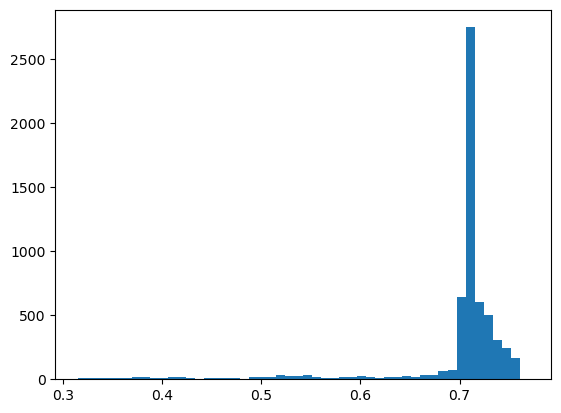

In [5]:
n_negative = (galaxies.zred < 0).sum()
print(f"Fraction of galaxies with negative redshift: {n_negative / len(galaxies):.3f}")
plt.hist(galaxies.zred[galaxies.zred > 0], bins=50);


In [6]:

# Fake spec-z catalog. The selector checks if any galaxies in the
# supplied catalog actually have spectroscopic redshifts. We don't
# want to do that here so we generate a fake mini-catalog that nothing
# will match.
dtype=[('ra', 'f8'), ('dec', 'f8')]
fake_spectroscopic_catalog = np.full(1, -1e30, dtype=dtype)

In [7]:

# This is the main selector object
vlim_masks = {"highdens": VolumeLimitMaskFixed(config)}
selector = redmagic.RedmagicSelector(config, vlim_masks=vlim_masks)
selector.spec = fake_spectroscopic_catalog

# This only has one mode in this configuration, highdens.
# I guess there's some configuration choice somewhere to add more?
selector.modes

# Should be "fixed" class
print(selector.vlim_masks)



{'highdens': <redmapper.volumelimit.VolumeLimitMaskFixed object at 0x1378a5ae0>}


# Selection

Right now this doesn't select anything! 

I had thought this was the volume limit mask not matching our data, but I replaced that with a fixed one and it didn't change anything.

It seems to be the zrange values specified in the file not overlapping with the redshifts found at all for the objects. This is a very small area (1 deg^2) but there should be something. Possibly a mag issue, or maybe we need a calibration object trained on CosmoDC2?

My branch of RedMapper added the print-outs here fore debugging.

In [8]:
selector.select_redmagic_galaxies(galaxies, "highdens", return_indices=True)

Cut zrange: [np.float32(0.0), np.float32(0.6)]
Above min count 5995
Below max count 81928
chisq okay 76205
refmag okay 1386
Galaxies: 82200
Good chi2 76205
Good refmag 1020
Good zredmagic 82200
Possible red galaxies: 0


(array([],
       dtype=[('id', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('refmag', '<f4'), ('refmag_err', '<f4'), ('mag', '<f4', (5,)), ('mag_err', '<f4', (5,)), ('lum', '<f4'), ('zredmagic', '<f4'), ('zredmagic_e', '<f4'), ('zredmagic_samp', '<f4', (30,)), ('chisq', '<f4'), ('zspec', '<f4')]),
 array([], dtype=int64))